In [52]:
import pandas as pd
import numpy as np

In [54]:
df_encoded = pd.read_csv("/Users/anthonymoubarak/Desktop/Gab_Project/imputed_dopen4.csv")
df_encoded.head()

,mace,CCOTHERAB,CCBYPASS,CCRENAL,DISTANAST,PROXCLAMP,GBODYDIA,EXP,ILIACANEUR,MAXAAADIA,...,PRIMARYINSURER,ETHNICITY,RACE,bmi,GENDER,AGE,SURGWEEKDAY,surgmonth_numeric,SURGYEAR,PHYSICIANID
0,0,0,0,0,1,1,18,1,0,90.0,...,3.0,1,5,29.860551,0,64,5,12,2016,11212
1,0,0,0,0,2,1,16,1,0,53.0,...,3.0,0,5,24.424689,0,73,4,9,2018,11204
2,0,0,0,0,2,2,16,1,0,50.0,...,1.0,0,5,31.246055,0,70,2,1,2013,11038
3,0,0,0,0,2,1,18,2,2,82.0,...,3.0,0,5,32.242063,0,74,2,10,2012,11038
4,0,0,0,0,2,1,16,1,1,43.0,...,1.0,0,5,35.646457,0,64,2,7,2013,11038


In [55]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Assuming your DataFrame is df2 and the target column is 'mace'
X = df_encoded.drop('mace', axis=1)  # Features
y = df_encoded['mace']               # Target

X.shape

(11160, 51)

## Method 1: ROSE after splitting into train/test

In [56]:
# Split to train and test 
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , random_state=42)


In [57]:
# Initialize the RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.5, random_state=42)

# Resample the dataset
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#### XGBoost

In [61]:
from scipy.stats import randint
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier # or any other model

# Define the parameter search space
search_space2 = {
    "n_estimators": randint(50, 1000),  # Random integers between 50 and 500
    "max_depth": randint(2, 30),  # Random integers between 2 and 9
    "learning_rate": [0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.0001],  # Specified learning rates
    "gamma": [0, 1, 1.5, 2, 3],  # Specified gamma values
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  # Specified colsample_bytree values
    "min_child_weight": randint(1, 20),  # Random integers between 1 and 10
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  # Specified subsample values
    "scale_pos_weight":[10,15 , 19, 26]
    
}




In [62]:
model = xgb.XGBClassifier(
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss',
    objective='binary:logistic',
    tree_method='hist'  # Other parameters will be chosen by RandomizedSearchCV
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=search_space2,
    n_iter=80,  # Number of parameter settings that are sampled
    cv=3,  # 5-fold cross-validation
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)


/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [63]:
random_search.fit(X_train_ros, y_train_ros)

/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x169897790>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1760a7340>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x174bd7d90>,
                                        'scale_pos_weight': [10, 15, 19, 26],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=42)

In [64]:
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 22, 'min_child_weight': 1, 'n_estimators': 305, 'scale_pos_weight': 19, 'subsample': 0.6}


In [65]:
# For predictions
predictions = best_model.predict(X_test)

# For model evaluation
score = best_model.score(X_test, y_test)
score

0.9411589008363201

In [66]:
from sklearn.metrics import roc_auc_score
probabilities = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probabilities)
print("ROC AUC Score:", auc_score)


ROC AUC Score: 0.6306524373821708


ROC AUC Score: 0.6306524373821708
AUC: 0.63
Accuracy: 0.94
Recall/Sensitivity: 0.03
Specificity: 1.00
Precision/PPV: 0.26
NPV: 0.95
F1 Score: 0.05


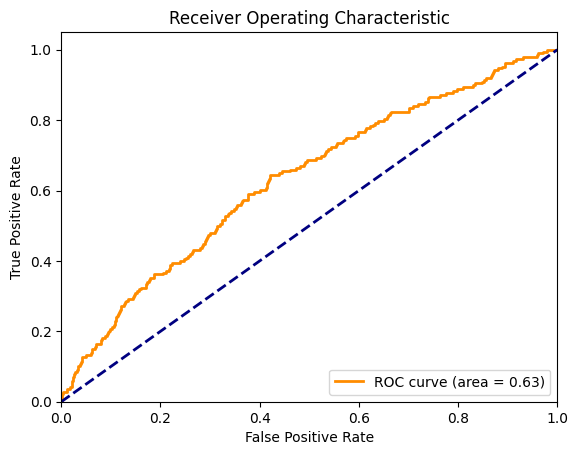

In [68]:
from sklearn.metrics import roc_auc_score
probabilities = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probabilities)
print("ROC AUC Score:", auc_score)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score, 
    recall_score, precision_score, f1_score
)
import xgboost as xgb

# Predict probabilities and class labels on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
recall_sensitivity = recall_score(y_test, y_pred)  # Recall is the same as sensitivity
precision_ppv = precision_score(y_test, y_pred)  # Precision is PPV
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
npv = tn / (tn + fn) if (tn + fn) != 0 else 0
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"AUC: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall/Sensitivity: {recall_sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision/PPV: {precision_ppv:.2f}")
print(f"NPV: {npv:.2f}")
print(f"F1 Score: {f1:.2f}")

#Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Fitting a specific model

In [70]:
# from numpy import nan  # Make sure to import nan if you are going to use it for missing values

# modelrs2 = xgb.XGBClassifier(
#     enable_categorical = True,
#     use_label_encoder=False,
#     eval_metric='logloss',
#     objective='binary:logistic',
#     n_estimators=150,  # Number of trees
#     colsample_bytree=0.6,  # Subsample ratio of columns when constructing each tree
#     learning_rate=0.3,  # Step size shrinkage used to prevent overfitting
#     max_depth=3,  # Maximum depth of a tree
#     min_child_weight=1,  # Minimum sum of instance weight (hessian) needed in a child
#     gamma=0,  # Minimum loss reduction required to make a further partition on a leaf node
#     subsample=0.9,  # Subsample ratio of the training instances
#     reg_lambda=1,  # L2 regularization term on weights
#     reg_alpha=0,  # L1 regularization term on weights
#     scale_pos_weight=1,  # Balancing of positive and negative weights
#     tree_method='hist',  # Use this for faster computation
#     #missing=nan  # Uncomment if you have missing values in your dataset
# )
# modelrs2.fit(X_train_ros, y_train_ros)

#### Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [73]:
search_space_rf = {
    "n_estimators": randint(50, 300),  # Random integers between 50 and 1000
    "max_depth": randint(2, 10),  # Random integers between 2 and 30
    "min_samples_split": randint(2, 20),  # Random integers for the minimum number of samples required to split an internal node
    "min_samples_leaf": randint(1, 20),  # Random integers for the minimum number of samples required to be at a leaf node
    "max_features": ['auto', 'sqrt', 'log2'],  # The number of features to consider when looking for the best split
    "bootstrap": [True, False]  # Whether bootstrap samples are used when building trees
}

In [74]:
model_rf = RandomForestClassifier(random_state=42)

random_search_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=search_space_rf,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=3,  # 5-fold cross-validation
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)


In [75]:
# Assuming X_train and y_train are your training data and labels
random_search_rf.fit(X_train_ros, y_train_ros)

/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x169896a40>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17601ebf0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1760d4280>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1760d6d40>},
                   random_state=42)

In [78]:
print("Best Parameters:", random_search_rf.best_params_)
best_model_rf = random_search_rf.best_estimator_

Best Parameters: {'bootstrap': False, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}


In [83]:
from sklearn.metrics import roc_auc_score
probabilities = best_model_rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, probabilities)
print("ROC AUC Score:", auc_score)


ROC AUC Score: 0.6690580393213036


AUC: 0.67
Accuracy: 0.94
Recall/Sensitivity: 0.01
Specificity: 1.00
Precision/PPV: 0.25
NPV: 0.94
F1 Score: 0.02


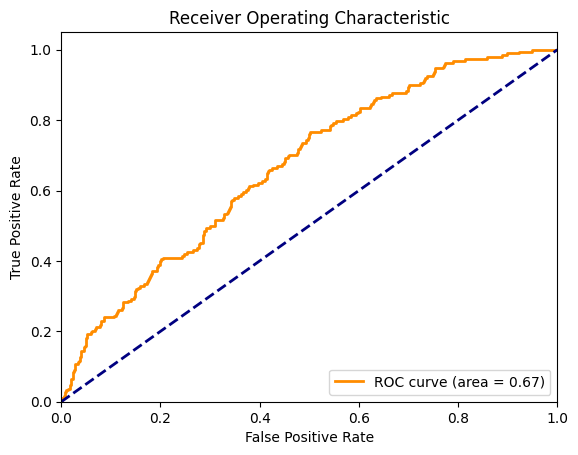

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score, 
    recall_score, precision_score, f1_score
)

# Predict probabilities and class labels on the test set
y_pred_proba = best_model_rf.predict_proba(X_test)[:, 1]
y_pred = best_model_rf.predict(X_test)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
recall_sensitivity = recall_score(y_test, y_pred)  # Recall is the same as sensitivity
precision_ppv = precision_score(y_test, y_pred)  # Precision is PPV
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
npv = tn / (tn + fn) if (tn + fn) != 0 else 0
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"AUC: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall/Sensitivity: {recall_sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision/PPV: {precision_ppv:.2f}")
print(f"NPV: {npv:.2f}")
print(f"F1 Score: {f1:.2f}")

#Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression()

# Training the model
log_reg.fit(X_train_ros, y_train_ros)

# Predicting probabilities on the test set
probabilities = log_reg.predict_proba(X_test)[:, 1]

# Calculating the AUC score
auc_score = roc_auc_score(y_test, probabilities)

# Output the AUC score
print("ROC AUC Score:", auc_score)

ROC AUC Score: 0.68462833288446


/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.68
Accuracy: 0.85
Recall/Sensitivity: 0.28
Specificity: 0.88
Precision/PPV: 0.12
NPV: 0.95
F1 Score: 0.17


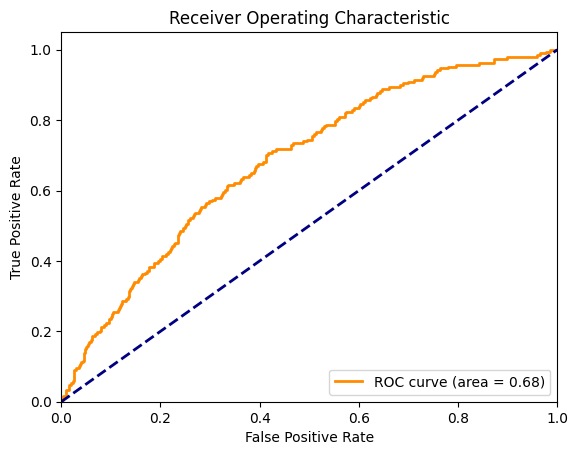

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, confusion_matrix, 
    accuracy_score, recall_score, precision_score, f1_score
)
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities and class labels on the test set
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
y_pred = log_reg.predict(X_test)

# Compute ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
recall_sensitivity = recall_score(y_test, y_pred)  # Recall is the same as sensitivity
precision_ppv = precision_score(y_test, y_pred)  # Precision is PPV
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
npv = tn / (tn + fn) if (tn + fn) != 0 else 0
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"AUC: {roc_auc:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall/Sensitivity: {recall_sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Precision/PPV: {precision_ppv:.2f}")
print(f"NPV: {npv:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Method 2: ROSE on the Whole Dataset

In [88]:
ros = RandomOverSampler(sampling_strategy=1, random_state=42)
X = df_encoded.drop('mace', axis=1)  # Features
y = df_encoded['mace']               # Target

X_ros, y_ros = ros.fit_resample(X, y)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.3 , random_state=42)

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Initialize Logistic Regression Model
log_reg = LogisticRegression()

# Training the model
log_reg.fit(X_train, y_train)

# Predicting probabilities on the test set
probabilities = log_reg.predict_proba(X_test)[:, 1]

# Calculating the AUC score
auc_score = roc_auc_score(y_test, probabilities)

# Output the AUC score
print("ROC AUC Score:", auc_score)


ROC AUC Score: 0.6987750662726246


/Users/anthonymoubarak/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


XGB

In [91]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()

In [92]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [93]:
y_pred = xgb_clf.predict(X_test)

In [94]:
from sklearn.metrics import roc_auc_score

# Predict the probabilities for each class
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")


AUC: 0.9992


Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier()

# Training the model
rf_clf.fit(X_train, y_train)

# Predict the class labels for the test set
y_pred = rf_clf.predict(X_test)

# Predict the probabilities for each class
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the AUC
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"AUC: {auc_score:.4f}")


AUC: 1.0000
